# 차원축소

In [1]:
import sys
assert sys.version_info>=(3,5)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os

In [2]:
np.random.seed(42)

투영 방법
- 3D 데이터 셋을 만든다.

In [3]:
np.random.seed(4)
m=60 # the number of samples
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2- 0.5
X = np.empty((m,3))
X[:,0] = np.cos(angles) + np.sin(angles)/2 + noise*np.random.randn(m)
X[:,1] = np.sin(angles) * 0.7 + noise*np.random.randn(m)/2
X[:,2] = X[:,0]*w1 + X[:,1]*w2 + noise*np.random.randn(m)

Text(0.5, 1.0, 'Series Data')

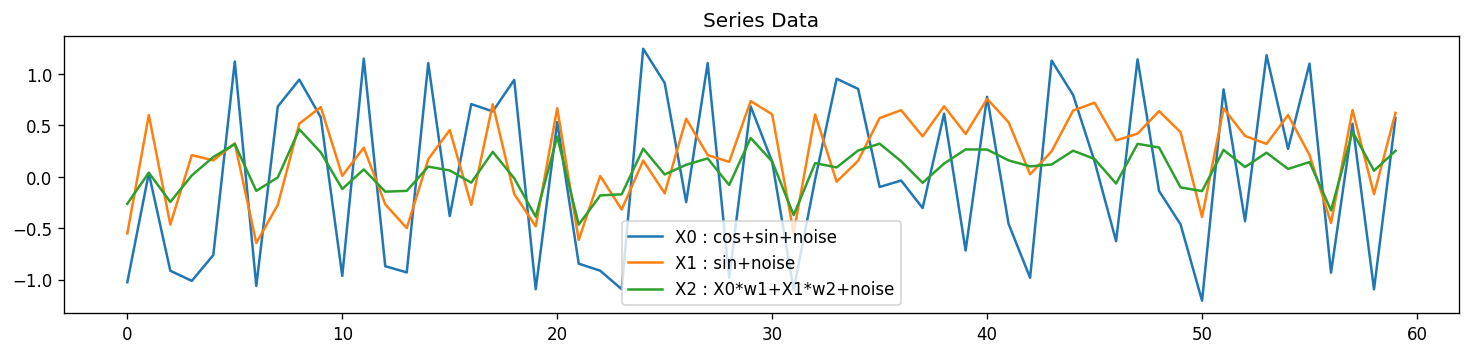

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,3),dpi=120, facecolor='w', edgecolor='k')
plt.plot(X[:,0],label = 'X0 : cos+sin+noise')
plt.plot(X[:,1],label = 'X1 : sin+noise')
plt.plot(X[:,2],label = 'X2 : X0*w1+X1*w2+noise')
plt.legend(loc='best')
plt.title('Series Data')

# SVD 분해를 사용한 PCA
- Singular Vector Decomposition

m: 샘플 개수, n:특성 개수

In [5]:
# 주성분이란 분산이 가장 큰 방향을 찾는것이라고 생각해야한다.
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
#(m,m) (m,n) (n,n)

# numpy에 이미 svd 함수가 있어서 활용할 수 있음.
# 각각의 열이 주성분이 된다.
# 최대로 얻을 수 있는 특성 수의 최대는 features 의 수임.
# 주성분 분석이기 때문에 그 이상의 수는 무의미
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

In [6]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n,:n] = np.diag(s) # 정방행렬은 아니지만, 대각성분만 가져온다.

In [7]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [8]:
W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)

In [9]:
X2D_using_svd = X2D # 투영된 데이터 셋

# 사이킷런을 이용한 PCA

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # 2차원으로 project 시킨다는 의미.
X2D = pca.fit_transform(X) # Fit와 Transform을 동시에 진행한다.

In [11]:
X2D.shape

(60, 2)

In [12]:
X2D[:5] # 2차원 데이터의 5 point 의 값.

array([[ 1.27402854,  0.42048585],
       [-0.11517729, -0.34069677],
       [ 1.14061111,  0.37571297],
       [ 0.98610061, -0.33562082],
       [ 0.73360128, -0.25307823]])

In [13]:
X2D_using_svd[:5]

array([[-1.27402854, -0.42048585],
       [ 0.11517729,  0.34069677],
       [-1.14061111, -0.37571297],
       [-0.98610061,  0.33562082],
       [-0.73360128,  0.25307823]])

- scikitlearn사용 값과 svd사용한 값은 똑같은데, 부호가 다름.

In [14]:
np.allclose(X2D, -X2D_using_svd)

True

- 평면(PCA 2D 부분공간)에 투영된 3D 포인트를 복원한다.

In [15]:
X3D_inv = pca.inverse_transform(X2D)

- 물론, 투영 단계에서 일부 정보를 잃어버리기 때문에, 복원된 3D 포인트가 원본 3D 포인트와 완전히 똑같지는 않다.

In [16]:
np.allclose(X3D_inv, X)

False

- 재구성 오차를 계산한다.

In [17]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010137688557166857

- SVD 방식의 역변환은 다음과 같다.

In [18]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2,:])

- 사이킷런의 PCA클래스는 자동으로 평균을 뺏던 것을 복원해주기 때문에 두 방식의 재구성 오차가 동일하지는 않다. 하지만 평균을 빼면 동일한 재구성을 얻을 수 있다.

In [19]:
# 실제 오차를 구하는 방법이라고 생각.
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

# pca.mean_을 빼는 이유는 원점에 맞춰진 것을 빼줘야한다.. 어차피 Normalized 된 데이터여서 그런가?

True

In [20]:
# pca의 component에 계산된 주성분이 계산되어 있다..?
pca.components_

array([[-0.93767008, -0.29621832, -0.18174027],
       [ 0.3374835 , -0.90094948, -0.27275433]])

In [21]:
Vt[:2]
# 첫번째 주성분이 첫줄
# 두번째 주성분이 2번째줄
# 동일하지만 부호가 다른것을 다시 발견할 수 있다.

array([[ 0.93767008,  0.29621832,  0.18174027],
       [-0.3374835 ,  0.90094948,  0.27275433]])

In [22]:
# 찾은 주성분이 얼마나 많은 것을 설명하고 있는가를 볼 수 있다.
pca.explained_variance_ratio_
# 첫번째 항목이 주성분1의 설명력 84.2%의 분산을 포함하고 있고.
# 두번째 항목이 주성분2의 설명력 14.6%의 분산을 설명한다.

array([0.83981432, 0.14898492])

In [23]:
pca.explained_variance_ratio_.sum()

0.9887992376970115

- 98.88%를 설명하고 있다고 볼 수 있다.
- 2D로 투영했기 때문에 분산의 1.1%를 잃었다고 할 수 있다.

In [24]:
np.square(s)/np.square(s).sum()
# SVD방식을 사용했을 때 설명된 분산의 비율을 계산하는 방법이다. (s는 행렬 S의 대각 성분이다)

array([0.83981432, 0.14898492, 0.01120076])

In [25]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
  def __init__(self, xs, ys, zs, *args, **kwargs):
    FancyArrowPatch.__init__(self,(0,0), (0,0), *args, **kwargs)
    self._verts3d = xs, ys, zs
  def do_3d_projection(self, renderer=None):
    xs3d, ys3d, zs3d = self._verts3d
    xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
    self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
    return np.min(zs)
  '''
  def draw(self, renderer):
    xs3d, ys3d, zs3d = self._verts3d
    xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
    self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
    FancyArrowPatch.draw(self,renderer)
  '''

In [26]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0,2]*x1 + R[1,2]*x2) / (1 - R[2,2])

<ipython-input-27-aa4500e09dea>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2],X3D_inv[i][2]],"k-",color="#505050")


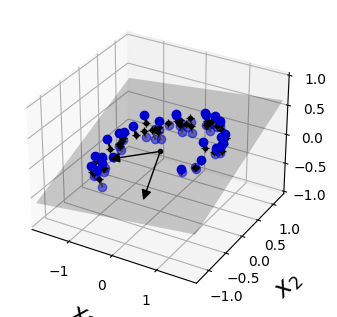

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:,2] > X3D_inv[:,2]]
X3D_below = X[X[:,2] <= X3D_inv[:,2]]

ax.plot(X3D_below[:,0], X3D_below[:,1], X3D_below[:,2], "bo", alpha=0.5)




ax.plot_surface(x1,x2,z,alpha=0.2, color="k")
np.linalg.norm(C, axis=0)

arrow_prop_dict = dict(mutation_scale=15, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0)
a = Arrow3D([0, C[0,0]], [0, C[0,1]], [0, C[0,2]], **arrow_prop_dict)
ax.add_artist(a)
arrow_prop_dict = dict(mutation_scale=15, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0)
a = Arrow3D([0, C[1,0]], [0, C[1,1]], [0, C[1,2]], **arrow_prop_dict)
ax.add_artist(a)

#ax.add_artist(Arrow3D([0, C[0,0]], [0,C[0,1]], [0,C[0,2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
#ax.add_artist(Arrow3D([0, C[1,0]], [0,C[1,1]], [0,C[1,2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0],[0], [0], "k.")

for i in range(m):
  if X[i,2] > X3D_inv[i,2]:
    ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2],X3D_inv[i][2]],"k-")
  else:
    ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2],X3D_inv[i][2]],"k-",color="#505050")

ax.plot(X3D_inv[:,0], X3D_inv[:,1], X3D_inv[:,2], "k+")
ax.plot(X3D_inv[:,0], X3D_inv[:,1], X3D_inv[:,2], "k.")
ax.plot(X3D_above[:,0], X3D_above[:,1], X3D_above[:,2], "bo")

ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)

ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
#save_fig("dataset_3d_plot")
plt.show()

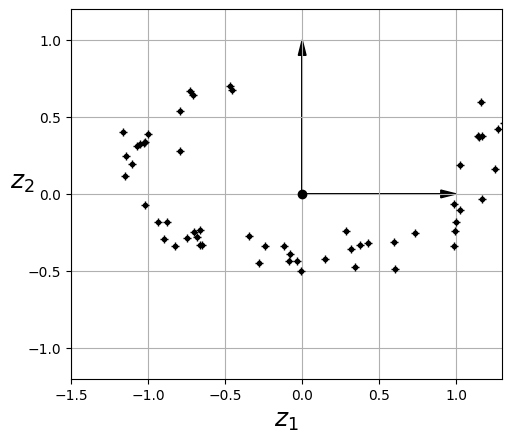

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:,0], X2D[:,1], "k+")
ax.plot(X2D[:,0], X2D[:,1], "k.")
ax.plot([0], [0], "ko")

ax.arrow(0,0,0,1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0,0,1,0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')

ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
#save_fig("dataset_2d_plot")

# 매니폴드 학습
- 스위스 롤:

In [29]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

(-12.0, 15.0)

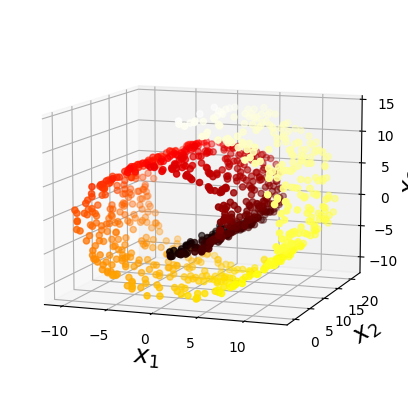

In [30]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c=t, cmap=plt.cm.hot)
ax.view_init(10,-70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)

ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

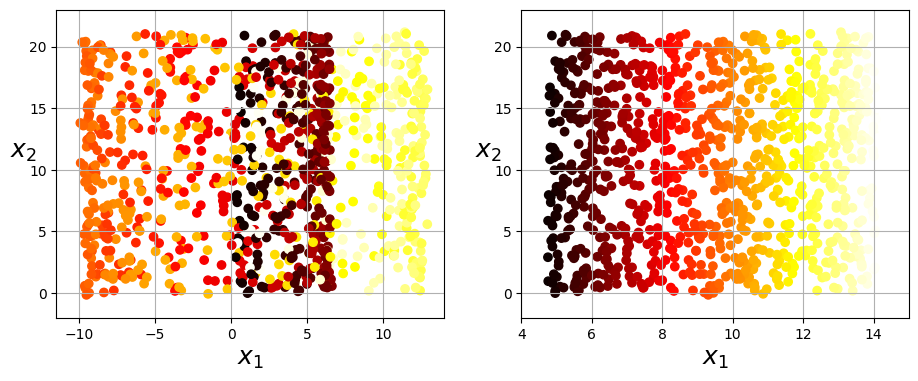

In [31]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:,1], c=t, cmap=plt.cm.hot)
plt.axis([4,15,axes[2],axes[3]])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)


In [32]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [33]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
# pca의 explained_variance_ratio_ 의 cumsum이 0.95이상을 찾는다는 의미는
# 누적합이 95%이상인 주성분 개수를 찾는다.
# 그게 154개
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d=np.argmax(cumsum>=0.95) +1

In [44]:
d

154

- 분산을 95%로 유지한다.
- 이것을 압축하는 과정으로 볼 수 있다.

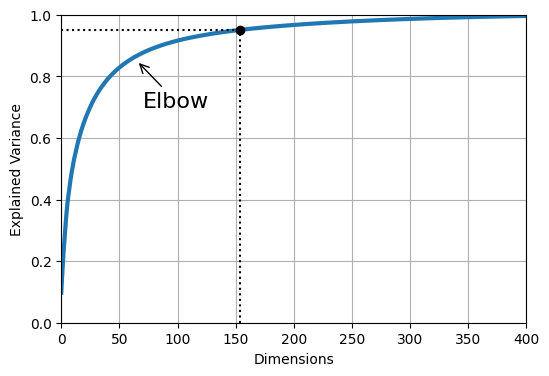

In [45]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d,d], [0, 0.95], "k:")
plt.plot([0,d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70,0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

 - 변곡점을 찾는것이적당한 디멘션..

In [ ]:
# 분산값으로 pca를 진행할 수도 있다.
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

In [ ]:
np.sum(pca.explained_variance_ratio_)

In [ ]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [81]:
import matplotlib as mpl
def plot_digits(instances, images_per_row=5, **options):
  size =28
  images_per_row = min(len(instances), images_per_row)
  #images = [instance.reshape(size,size) for instance in instances]
  if isinstance(instances, pd.DataFrame):
    images = [instances.iloc[i].values.reshape(size,size) for i in range(len(instances))]
  elif isinstance(instances, np.ndarray):
    images = [instances[i].reshape(size,size) for i in range(len(instances))]
  n_rows = (len(instances) - 1) // images_per_row +1
  row_images = []
  n_empty = n_rows * images_per_row - len(instances)
  images.append(np.zeros((size, size * n_empty)))

  for row in range(n_rows):
    rimages = images[row*images_per_row : (row+1)*images_per_row]
    row_images.append(np.concatenate(rimages, axis=1))
  image = np.concatenate(row_images, axis=0)
  plt.imshow(image, cmap=mpl.cm.binary, **options)
  plt.axis("off")

In [82]:
#X_train[::2100][0].reshape(28,28)
#X_train[::2100].iloc[0]

In [83]:
#X_train[::1].values.reshape(28,28)
X_recovered[::2100][0].shape

(784,)

Text(0.5, 1.0, 'Compressed')

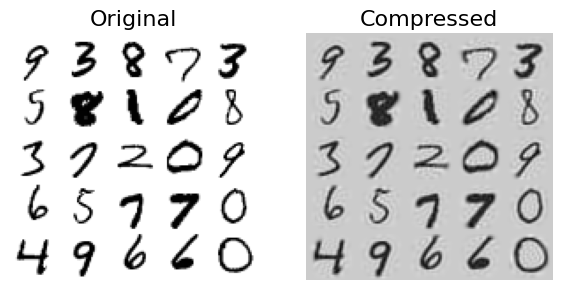

In [84]:
plt.figure(figsize=(7,4))

plt.subplot(121)
plot_digits(X_train[::2100])
# 784*25 == 2100
plt.title("Original",fontsize=16)

plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

- 유실되거나 깨끗하지 않은 부분이 있긴함.

In [86]:
X_reduced_pca = X_reduced

# 점진적 PCA(Incremental PCA)

In [88]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
  print(".", end="")
  inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train) # 내부에서 partial_fit을 수행하게 될 것임.
# 메모리가 부족하니까.. 조금씩 잘라서 fitting해나간다..?

....................................................................................................

In [89]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

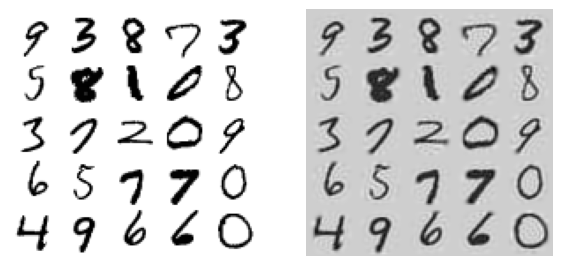

In [90]:
plt.figure(figsize=(7,4))

plt.subplot(121)
plot_digits(X_train[::2100])

plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])

plt.tight_layout

In [91]:
X_reduced_inc_pca = X_reduced

- 하지만 결과는 완전히 동일하지 않다. Incremental PCA는 아주 훌륭한 근사치를 제공하지만 완벽하지 않다.

In [92]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

# memmap() 사용하기

In [93]:
# Random
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

# Kernel PCA

In [95]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [97]:
from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components =2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)
# rbf kernel이 가우시안 커널임?

In [99]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components =2 , kernel = "linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components =2 , kernel = "rbf", gamma = 0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components =2 , kernel = "sigmoid", gamma = 0.001, coef0=1, fit_inverse_transform=True)

y = t>6.9

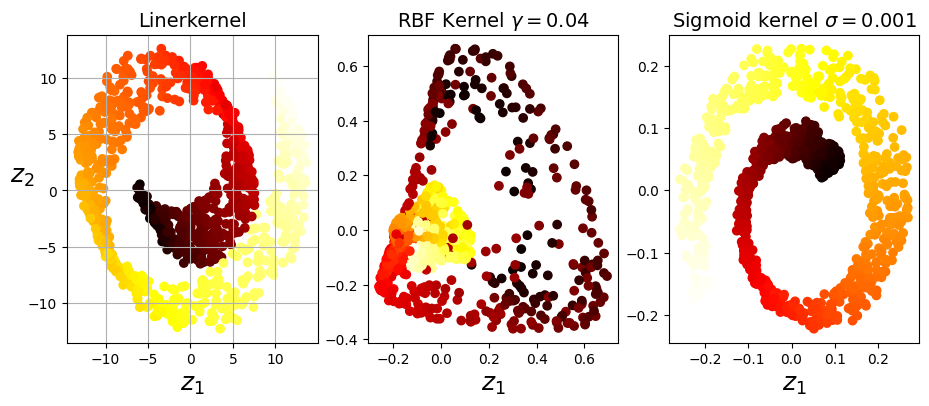

In [101]:
plt.figure(figsize=(11,4))
for subplot, pca, title in ((131,lin_pca,"Linerkernel"),(132,rbf_pca,"RBF Kernel $\gamma=0.04$"),(133,sig_pca,"Sigmoid kernel $\sigma=0.001$")):
  X_reduced = pca.fit_transform(X)
  if subplot == 132:
    X_reduced_rbf = X_reduced

  plt.subplot(subplot)
  plt.title(title, fontsize=14)
  plt.scatter(X_reduced[:,0],X_reduced[:,1],c=t, cmap=plt.cm.hot)
  plt.xlabel("$z_1$",fontsize=18)
  if subplot==131:
    plt.ylabel("$z_2$",fontsize=18,rotation=0)
    plt.grid(True)

plt.show()


- 여기서는 RBF가 구분하기 좀 더 좋지 않을까..? 라고 함

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression(solver="lbfgs"))
])

param_grid=[{
    "kpca__gamma":np.linspace(0.03,0.05,10),
    "kpca__kernel":["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid,cv=3)
grid_search.fit(X,y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [106]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [107]:
rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [108]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576607